## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 4: Algoritmo de filtraje no lineal en tiempo discreto**

#### **Estimación de parámetros con MCMC**

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [2]:
chapter = "chapter4/"
img_path = "img/content/"+chapter

In [3]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import odeint
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as Cte

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de KKF
from kkf.DynamicalSystems import DynamicalSystem
from kkf.kEDMD import KoopmanOperator
import kkf.applyKKF as kkf

# Paralelización
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Pandas
import pandas as pd

# Para medir el tiempo
from time import time

# Dependencias de PyMC 
import arviz as az
import pymc as pm
import pytensor
from pymc.ode import DifferentialEquation
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

In [4]:
pytensor.config.optimizer = 'fast_compile'
pytensor.config.exception_verbosity = 'high'

In [5]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'figure.figsize': (14, 8)})
plt.rcParams.update({'figure.titlesize': 24})

In [6]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

In [7]:
# Se fija la semilla aleatoria
np.random.seed(42)

In [8]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [9]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

In [10]:
theta = np.array([0.1, 0.1])  
with pm.Model() as model:
    # Priors
    beta_ = pm.Uniform("beta", lower=0, upper=2, initval=theta[0])
    gamma_ = pm.Uniform("gamma", lower=0, upper=1, initval=theta[1])

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

In [ ]:
np.random.seed(42)

vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 20000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
met_time = time() - met_time
trace = trace_DEMZ
az.summary(trace)

In [ ]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 104.11 s


In [ ]:
params = ['beta', 'gamma']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SIR_DEMetropolisZ.csv", index=False)

Parámetros estimados:
beta: 1.587 (0.95588, 2.21812)
gamma: 0.693 (0.22847999999999996, 1.1575199999999999)


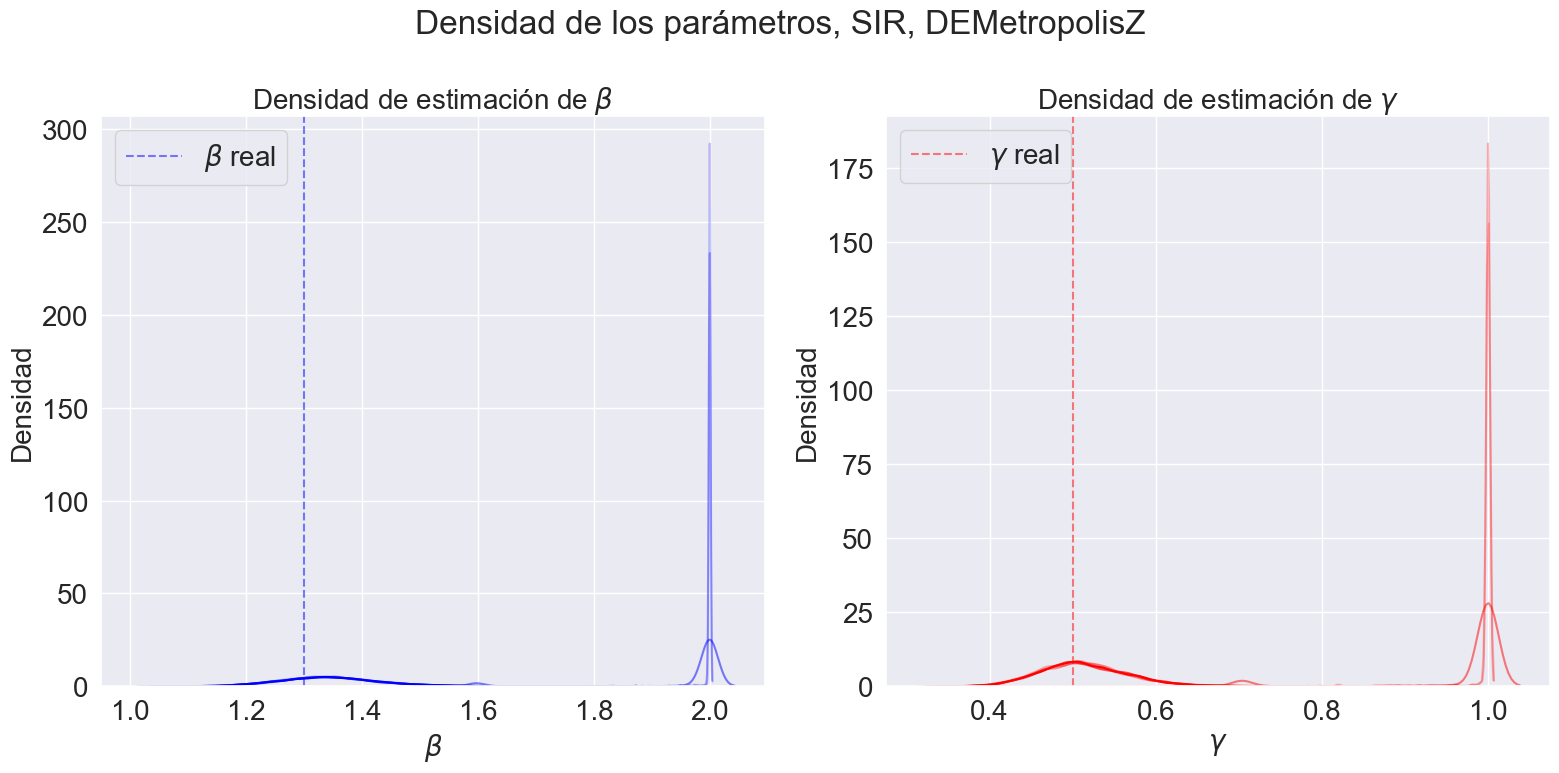

In [ ]:
beta_trace = trace.posterior["beta"].shape
gamma_trace = trace.posterior["gamma"].shape

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_density.pdf')

beta: 1.587 (0.95588, 2.21812)
gamma: 0.693 (0.22847999999999996, 1.1575199999999999)


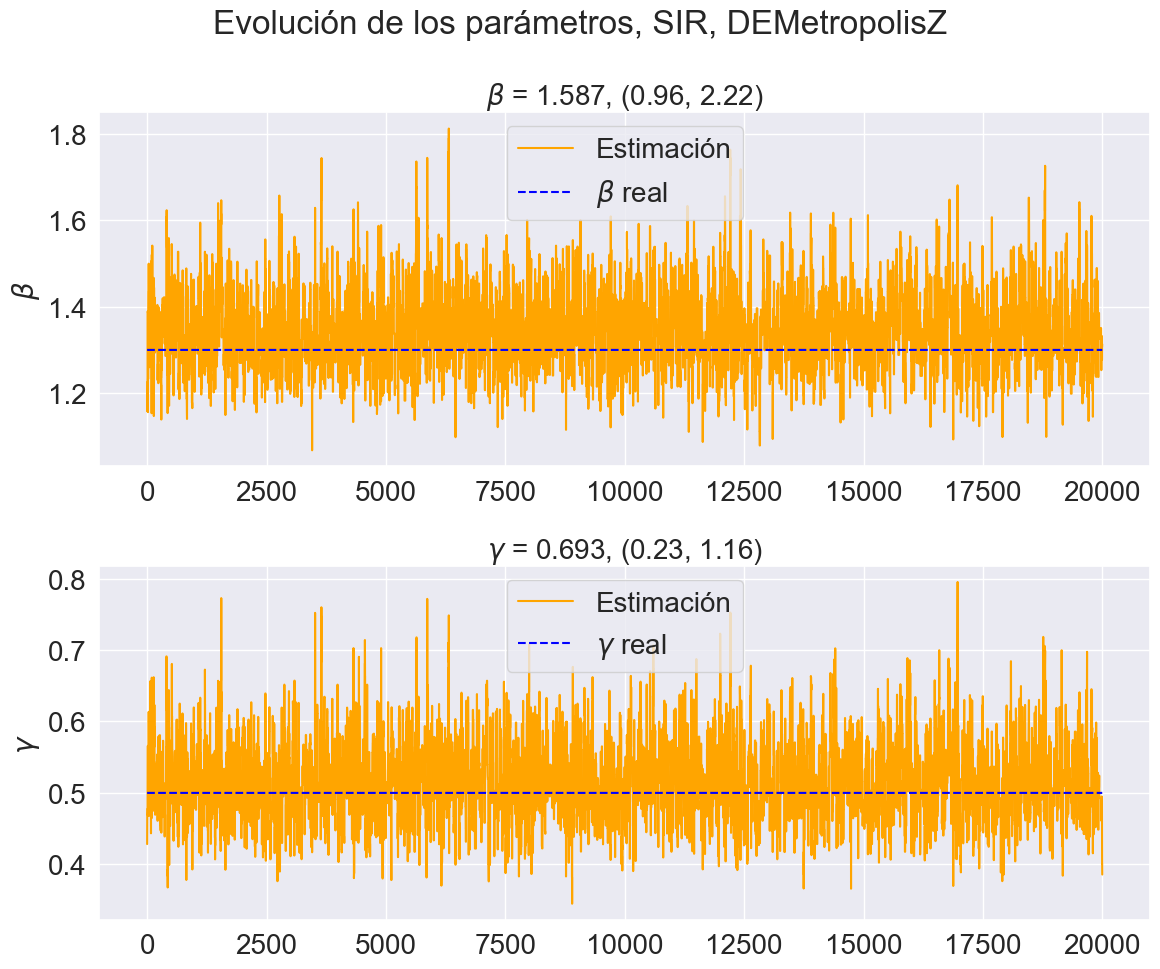

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[0].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[0].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[0].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[0].set_ylabel(r'$\beta$')
ax[0].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[1].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[1].plot([0.5]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[1].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[1].set_ylabel(r'$\gamma$')
ax[1].legend()

fig.suptitle('Evolución de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_trace.pdf')

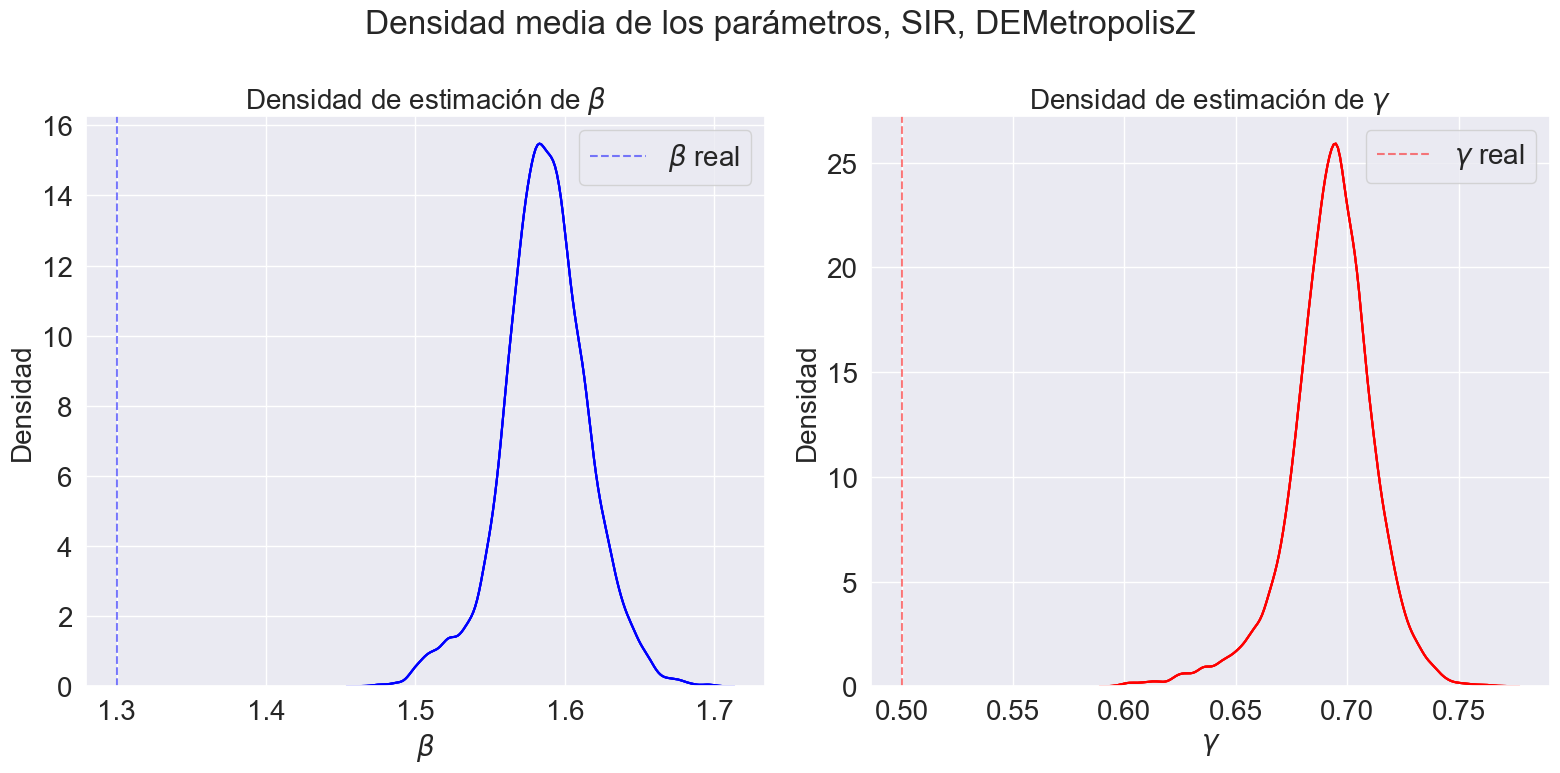

In [ ]:
beta_trace = trace.posterior["beta"].shape
gamma_trace = trace.posterior["gamma"].shape

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad media de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_density_mean.pdf')

### Modelo SIRS

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    alpha_, beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], alpha_, beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

theta = np.array([0.1, 0.1, 0.1])  
with pm.Model() as model:
    # Priors
    alpha_ = pm.Uniform("alpha", lower=0, upper=1)
    beta_ = pm.Uniform("beta", lower=0, upper=2)
    gamma_ = pm.Uniform("gamma", lower=0, upper=1)

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([alpha_, beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

np.random.seed(42)

vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 20000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
met_time = time() - met_time

In [ ]:
trace = trace_DEMZ
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.311,0.288,0.149,1.0,0.095,0.070,20.0,10514.0,1.33
beta,1.400,0.266,1.124,2.0,0.081,0.061,17.0,27.0,1.44
gamma,0.572,0.181,0.433,1.0,0.059,0.043,17.0,45.0,1.42


In [ ]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 120.61 s


In [ ]:
params = ['alpha', 'beta', 'gamma']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SIRS_DEMetropolisZ.csv", index=False)

Parámetros estimados:
alpha: 0.311 (-0.25348, 0.87548)
beta: 1.4 (0.8786399999999999, 1.92136)
gamma: 0.572 (0.21724, 0.9267599999999999)


alpha: 0.311 (-0.25348, 0.87548)
beta: 1.4 (0.8786399999999999, 1.92136)
gamma: 0.572 (0.21724, 0.9267599999999999)


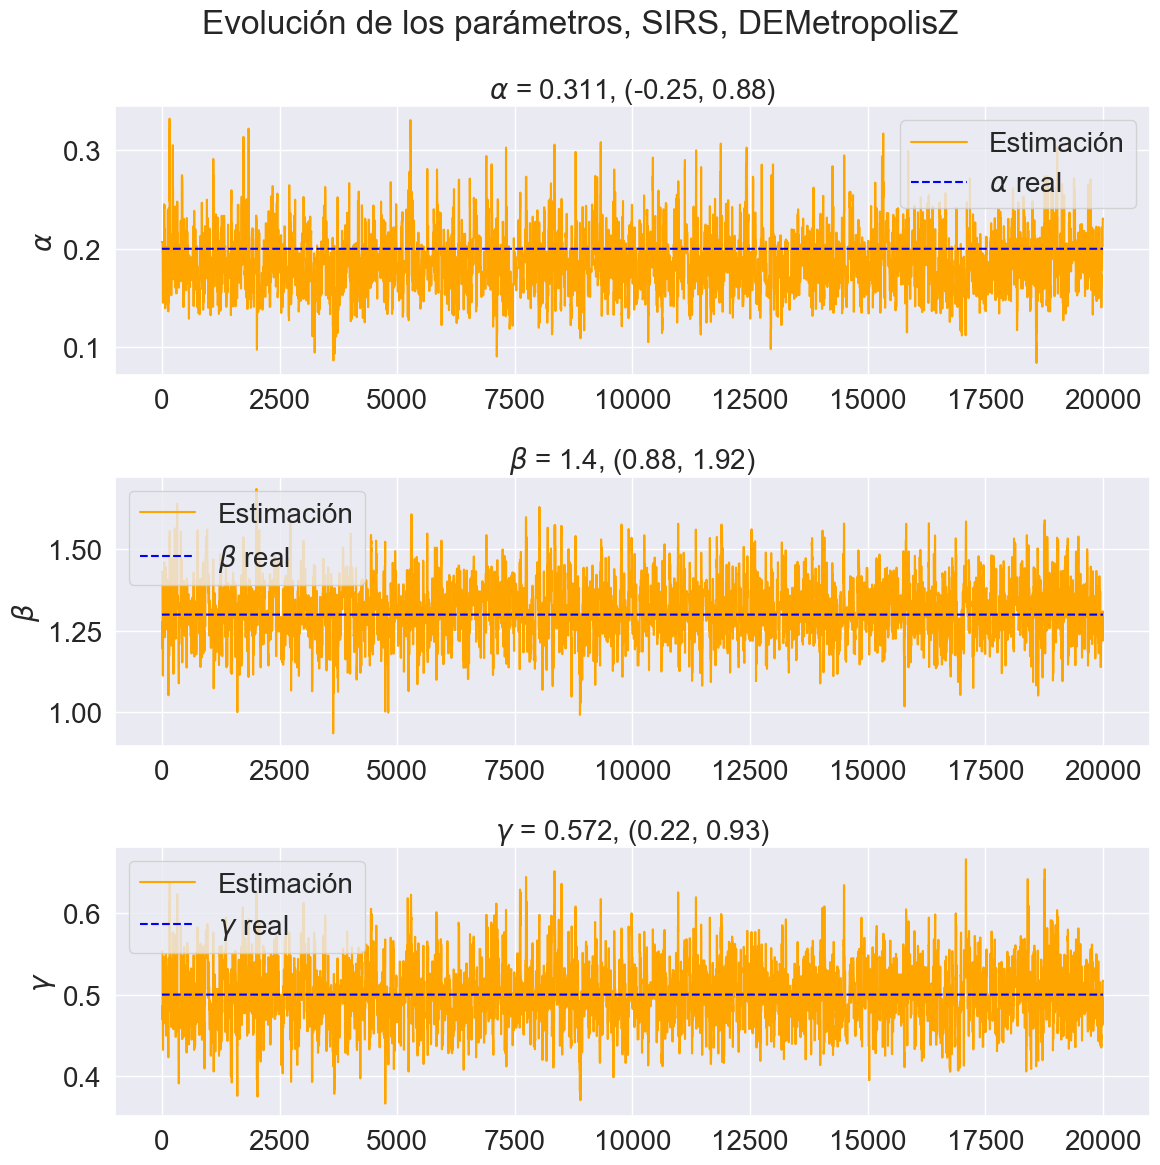

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot(trace.posterior["alpha"][0], c='orange', label='Estimación')
ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), c='blue', linestyle='--', label=r'$\alpha$ real')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[1].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[2].plot([0.5]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

fig.suptitle('Evolución de los parámetros, SIRS, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sirs_params_trace.pdf')

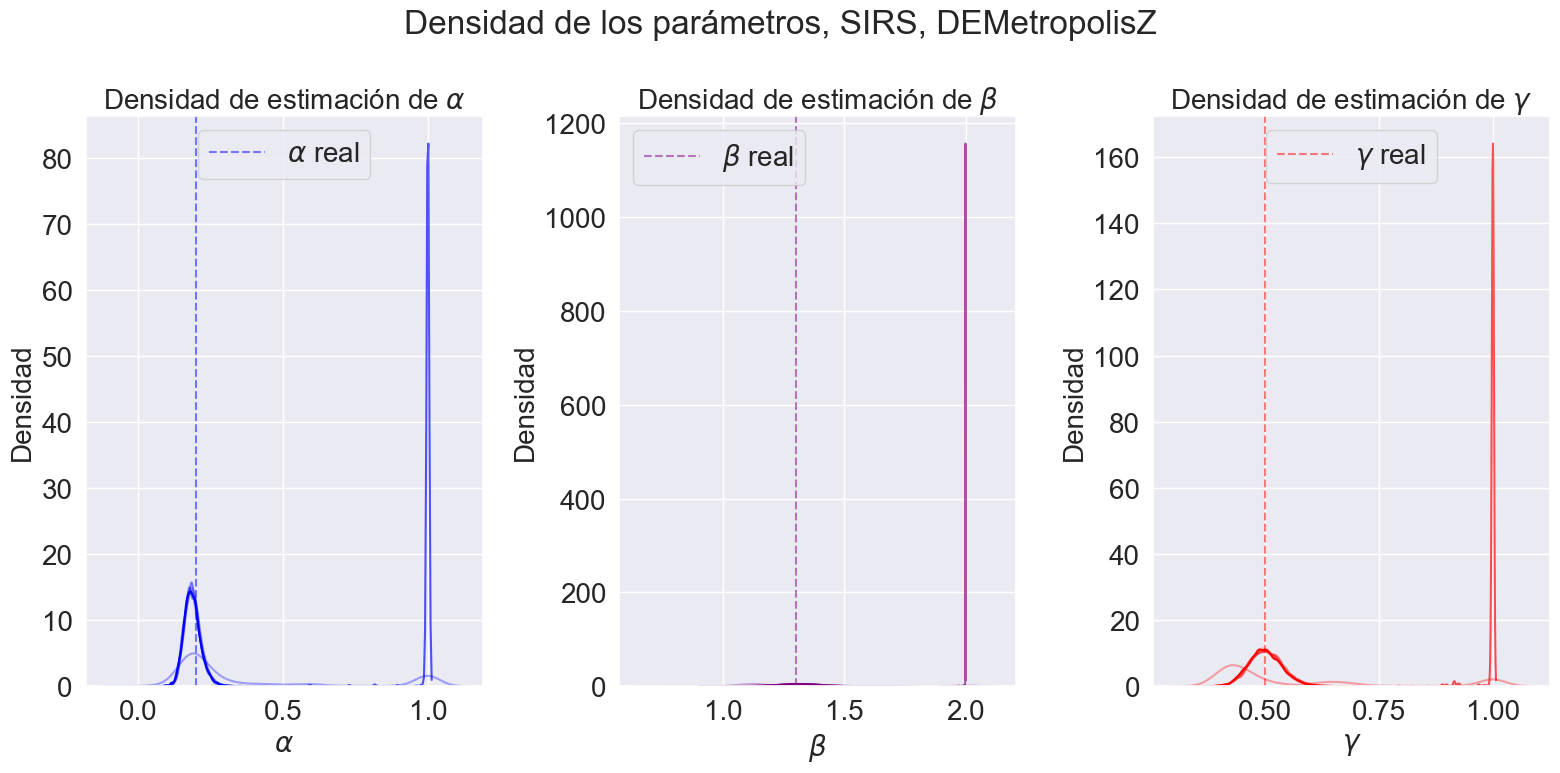

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de los parámetros, SIRS, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sirs_params_density.pdf')

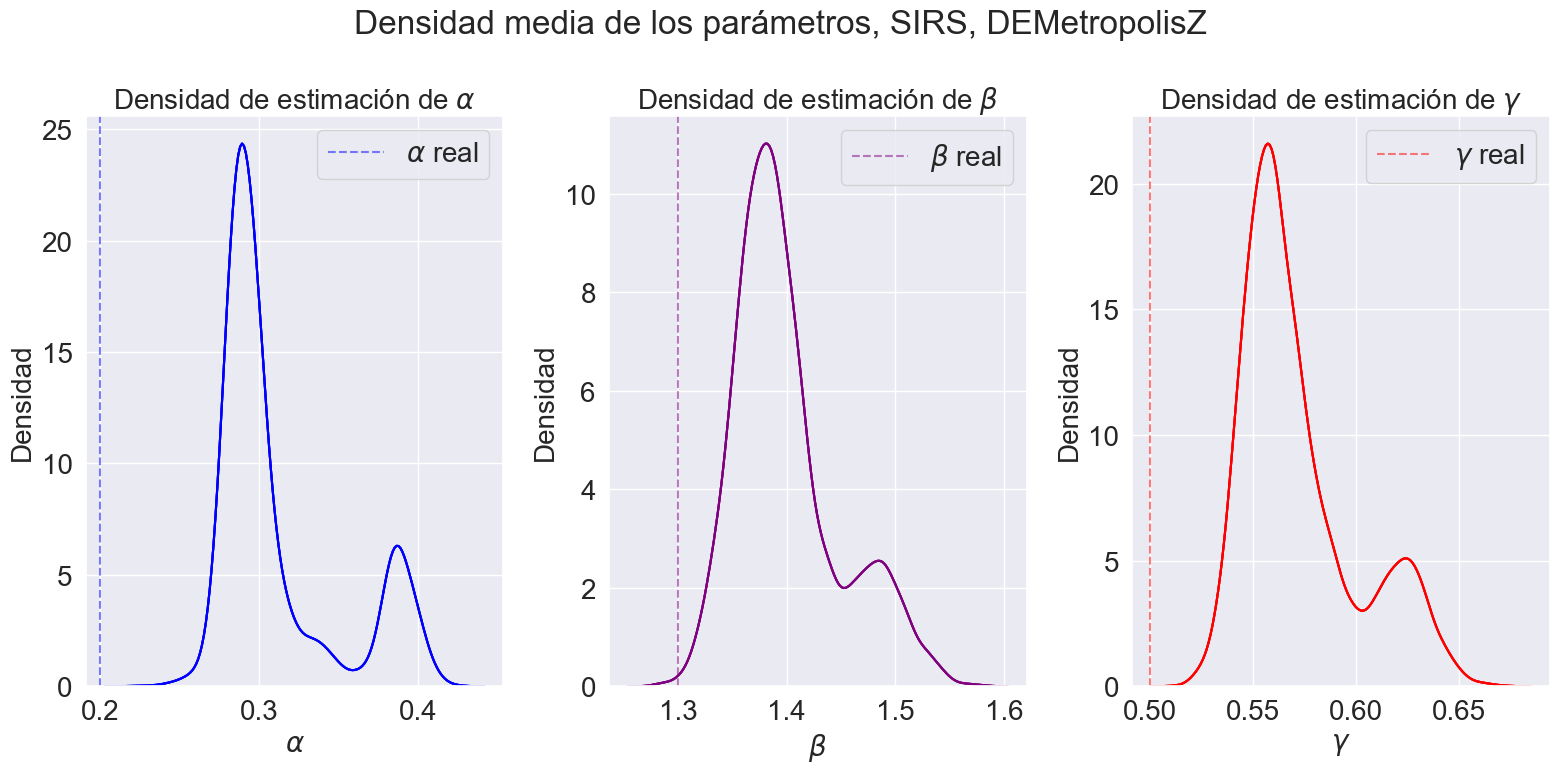

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad media de los parámetros, SIRS, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sirs_params_density_mean.pdf')

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma, delta):
    S, E, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - delta*E,
        delta*E - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[2]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.4
delta = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma, delta)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [ ]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    alpha, beta, gamma, delta = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], alpha, beta, gamma, delta)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

In [ ]:
theta = [0.1, 0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha_ = pm.Uniform("alpha", 0, 1)
    beta_ = pm.Uniform("beta", 0, 2)
    gamma_ = pm.Uniform("gamma", 0, 1)
    delta_ = pm.Uniform("delta", 0, 1)
    #sigma_ = pm.HalfNormal("sigma", sigma=0.1)

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([alpha_, beta_, gamma_, delta_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

In [ ]:
np.random.seed(42)

sampler = "DEMetropolisZ"
tune = draws = 20000
time_met = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ()], tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
time_met = time() - time_met

In [ ]:
trace = trace_DEMZ
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.923,0.196,0.417,1.000,0.006,0.004,1870.0,1649.0,1.0
beta,1.998,0.016,1.999,2.000,0.000,0.000,3181.0,2466.0,1.0
gamma,0.549,0.054,0.448,0.653,0.001,0.001,4205.0,6184.0,1.0
delta,0.372,0.063,0.259,0.491,0.001,0.001,4420.0,5919.0,1.0


In [ ]:
print(f"Tiempo de ejecución: {time_met:.2f} s")

Tiempo de ejecución: 127.82 s


In [ ]:
params = ['alpha', 'beta', 'gamma', 'delta']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SEIR_DEMetropolisZ.csv", index=False)

Parámetros estimados:
alpha: 0.923 (0.53884, 1.30716)
beta: 1.998 (1.96664, 2.02936)
gamma: 0.549 (0.44316000000000005, 0.6548400000000001)
delta: 0.372 (0.24852000000000002, 0.49548)


alpha: 0.923 (0.53884, 1.30716)
beta: 1.998 (1.96664, 2.02936)
gamma: 0.549 (0.44316000000000005, 0.6548400000000001)
gamma: 0.549 (0.44316000000000005, 0.6548400000000001)


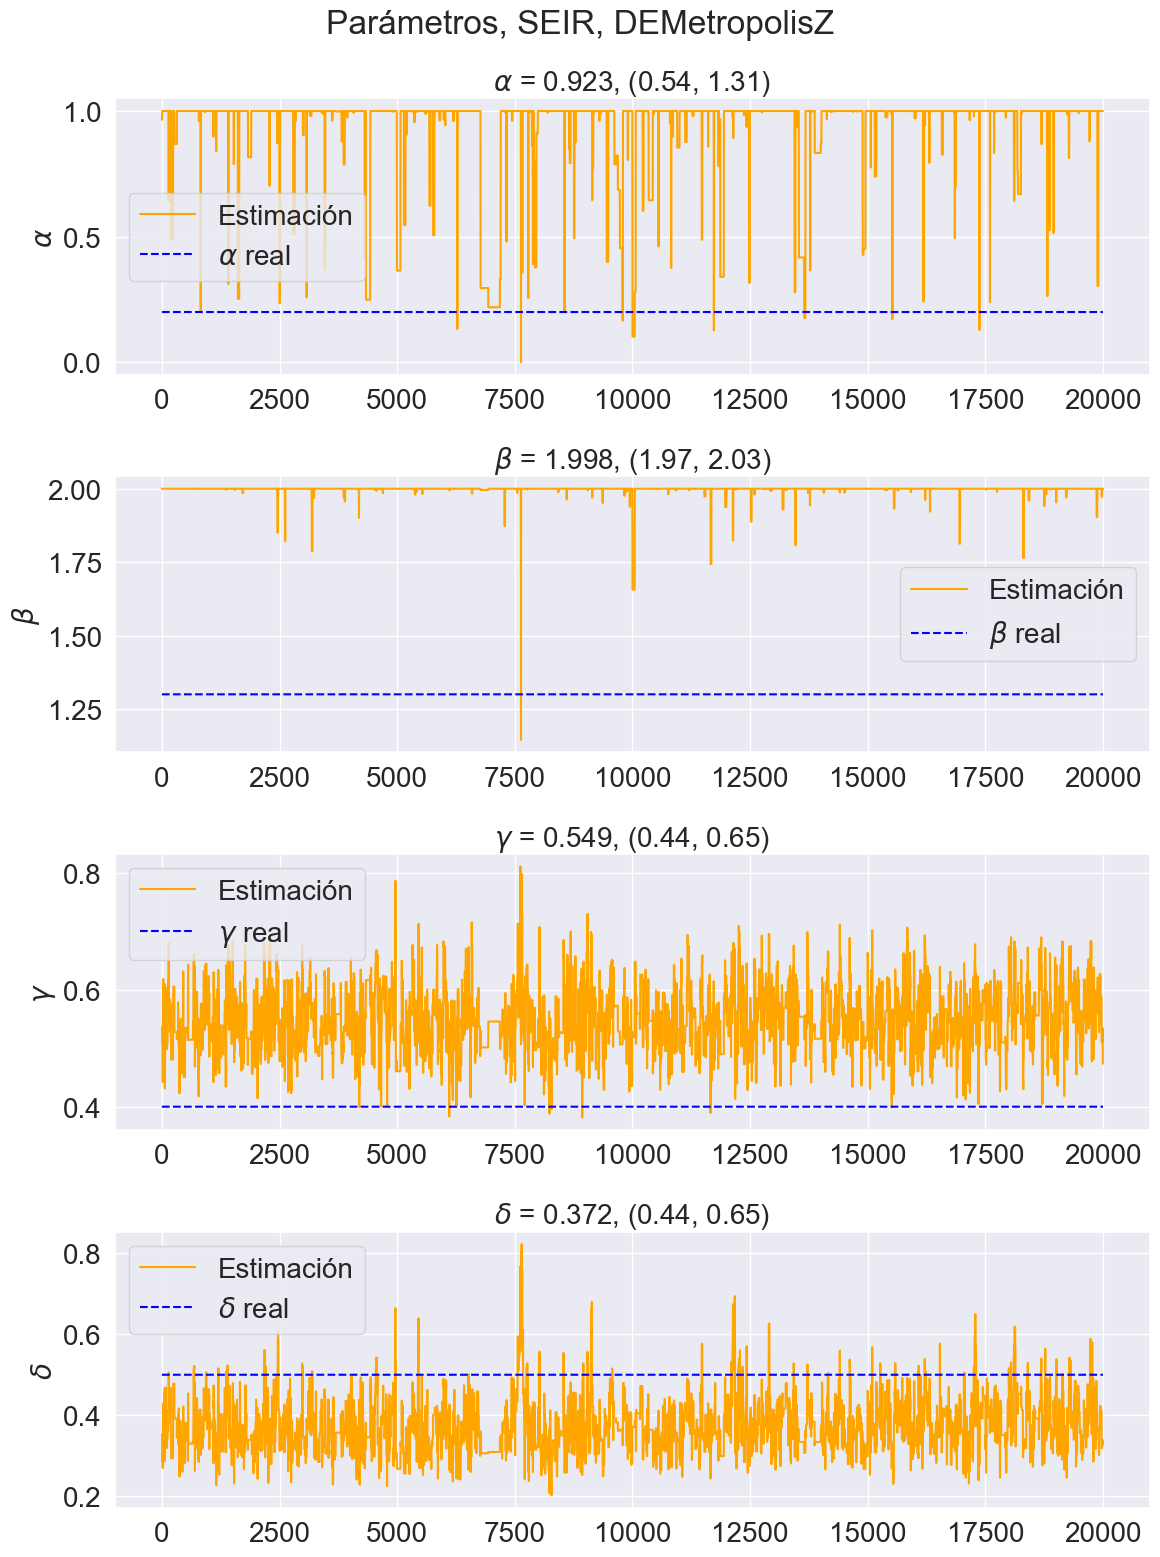

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot(trace.posterior["alpha"][0], c='orange', label='Estimación')
ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), c='blue', linestyle='--', label=r'$\alpha$ real')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[1].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[2].plot([0.4]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[3].plot(trace.posterior["delta"][0], c='orange', label='Estimación')
ax[3].plot([0.5]*len(trace.posterior["delta"][0]), c='blue', linestyle='--', label=r'$\delta$ real')
ax[3].set_title(r'$\delta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['delta'], z1, z2))
ax[3].set_ylabel(r'$\delta$')
ax[3].legend()

plt.suptitle('Parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_trace.pdf')

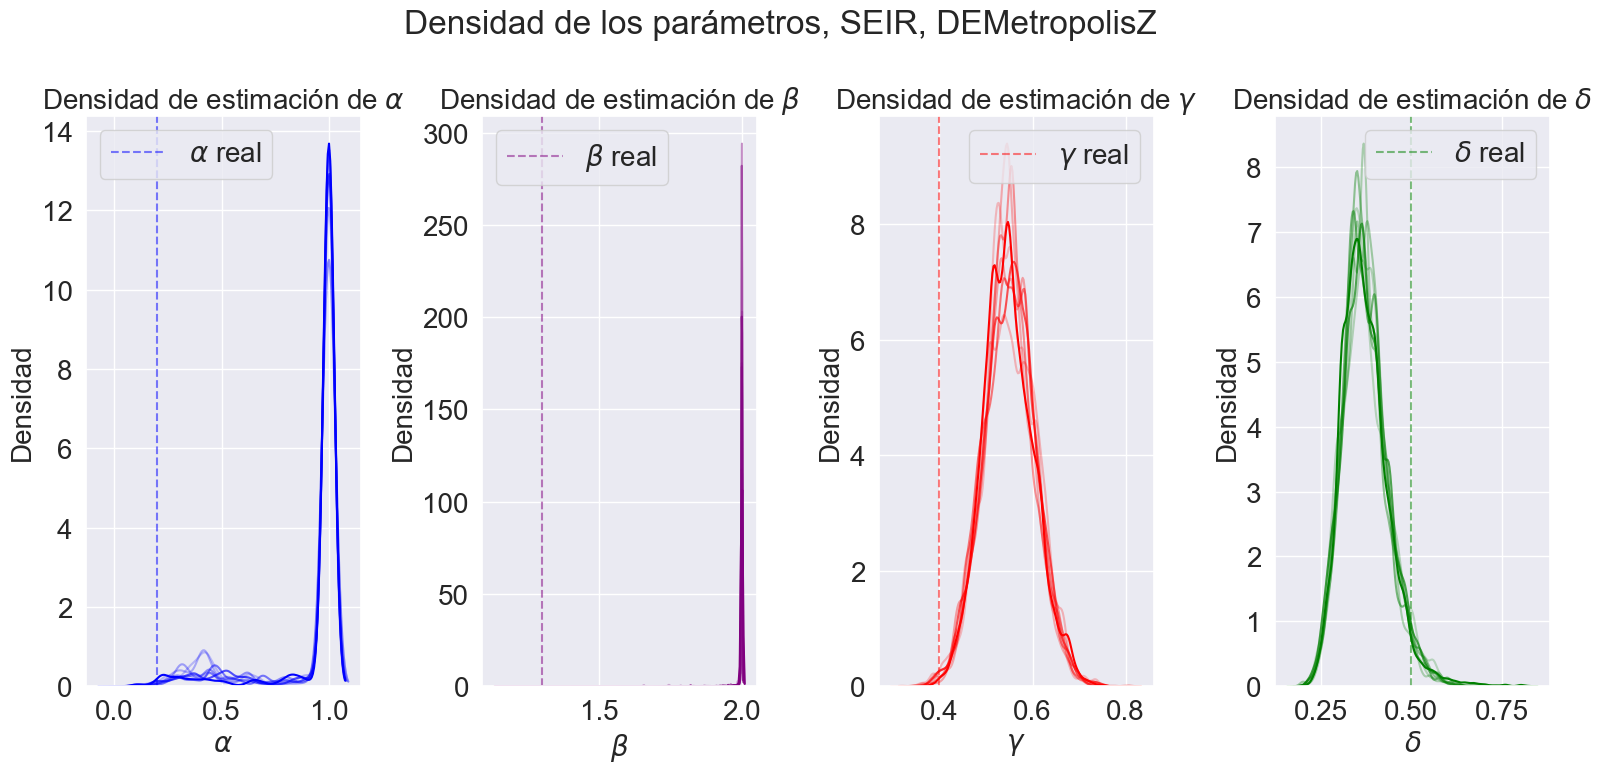

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"][i], ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(delta, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad de los parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_density.pdf')

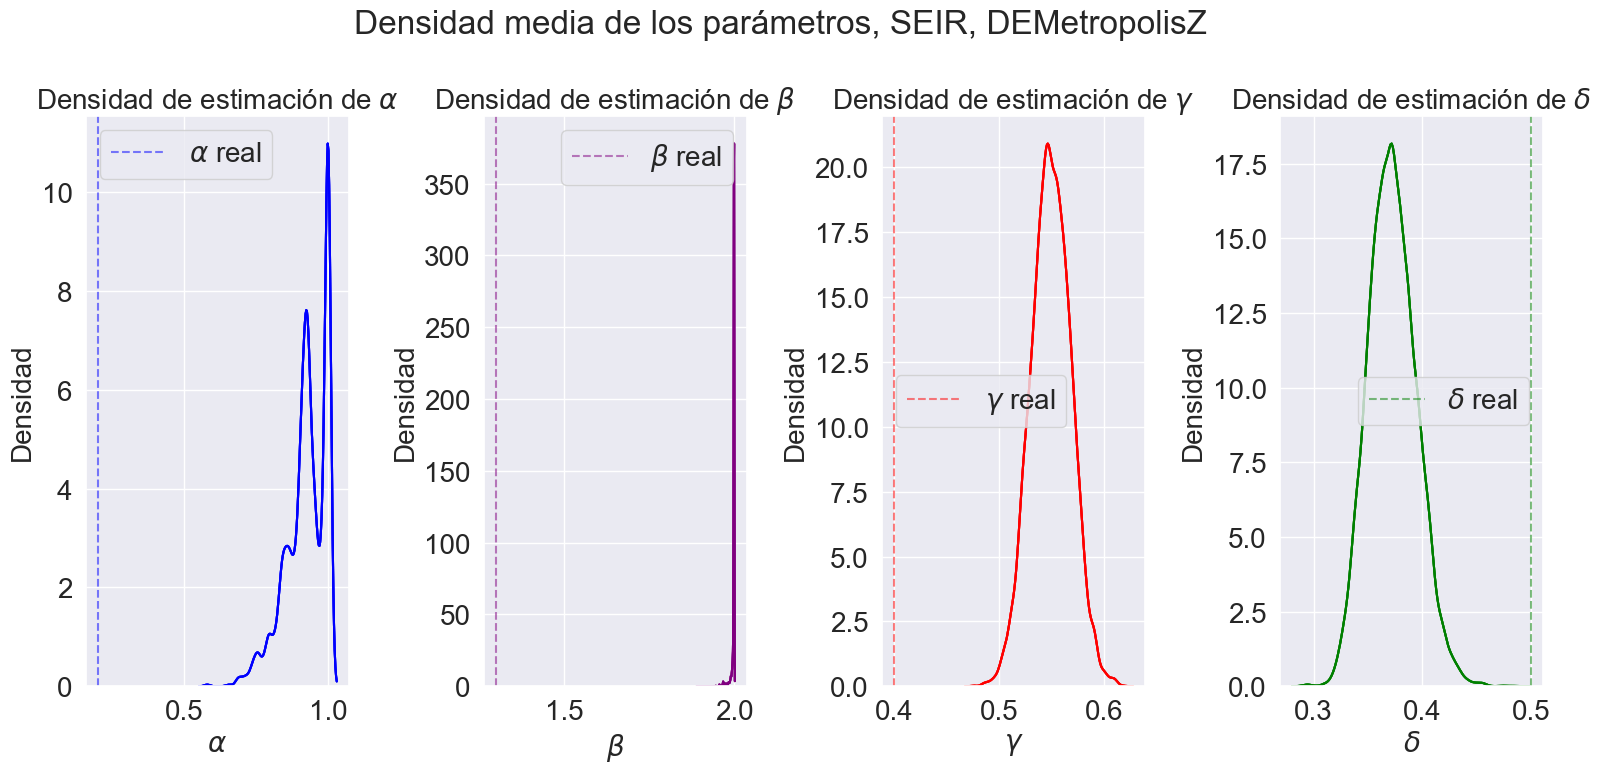

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"].mean(axis=0), ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(delta, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad media de los parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_density_mean.pdf')

## NUTS

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [ ]:
def rhs_pymcode(y, t, p):
    dS_dt = -p[0]*y[0]*y[1]
    dI_dt = p[0]*y[0]*y[1] - p[1]*y[1]
    dR_dt = p[1]*y[1]
    return [dS_dt, dI_dt, dR_dt]

In [ ]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=2, t0=0
)

In [ ]:
with pm.Model() as model:
    # Priors
    beta = pm.Uniform("beta", lower=0, upper=2)
    gamma = pm.Uniform("gamma", lower=0, upper=1)
    #sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=0.01, observed=y.T)

In [ ]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
time_nuts = time() - time_nuts

In [ ]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.334,0.010,1.316,1.354,0.001,0.0,379.0,481.0,1.02
gamma,0.446,0.005,0.436,0.455,0.000,0.0,408.0,376.0,1.02


In [ ]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 112.00 s


In [ ]:
params = ['beta', 'gamma']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SIR_NUTS.csv", index=False)

Parámetros estimados:
beta: 1.334 (1.3144, 1.3536000000000001)
gamma: 0.446 (0.43620000000000003, 0.4558)


beta: 1.334 (1.3144, 1.3536000000000001)
gamma: 0.446 (0.43620000000000003, 0.4558)


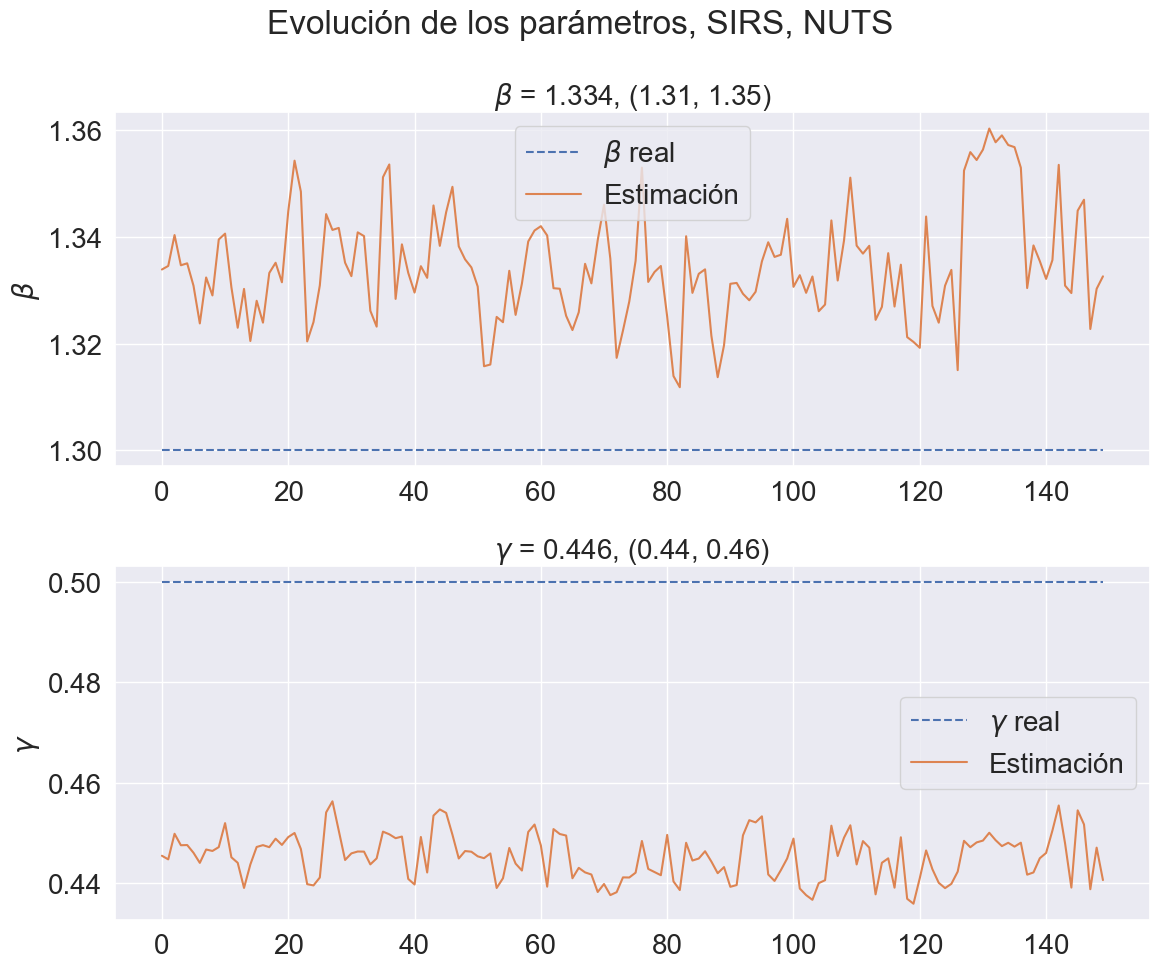

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[0].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[0].plot(trace.posterior["beta"][0], label='Estimación')
ax[0].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[0].set_ylabel(r'$\beta$')
ax[0].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[1].plot([0.5]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[1].plot(trace.posterior["gamma"][0], label='Estimación')
ax[1].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[1].set_ylabel(r'$\gamma$')
ax[1].legend()

fig.suptitle('Evolución de los parámetros, SIRS, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_trace.pdf')

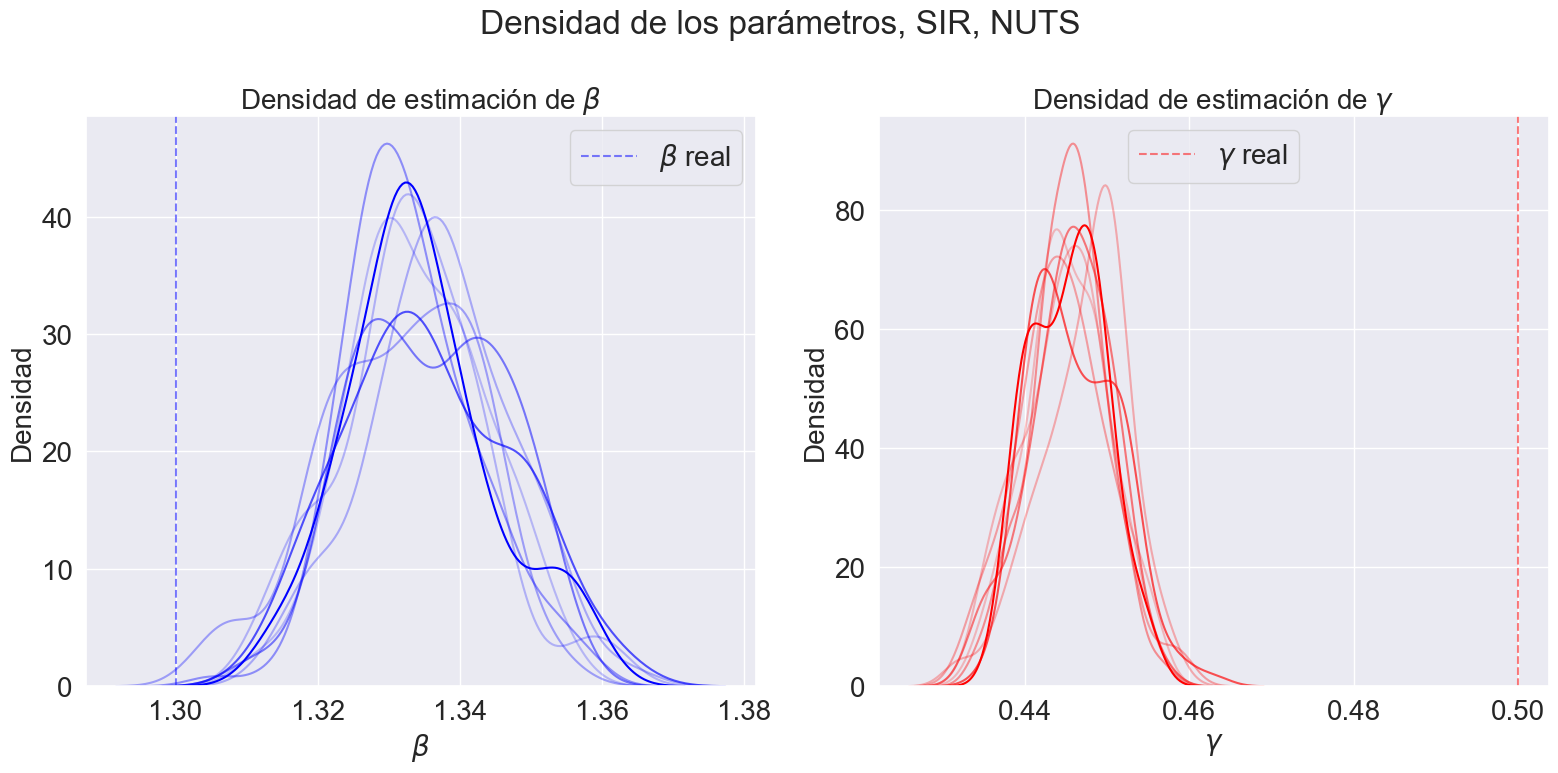

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.3, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de los parámetros, SIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_density.pdf')

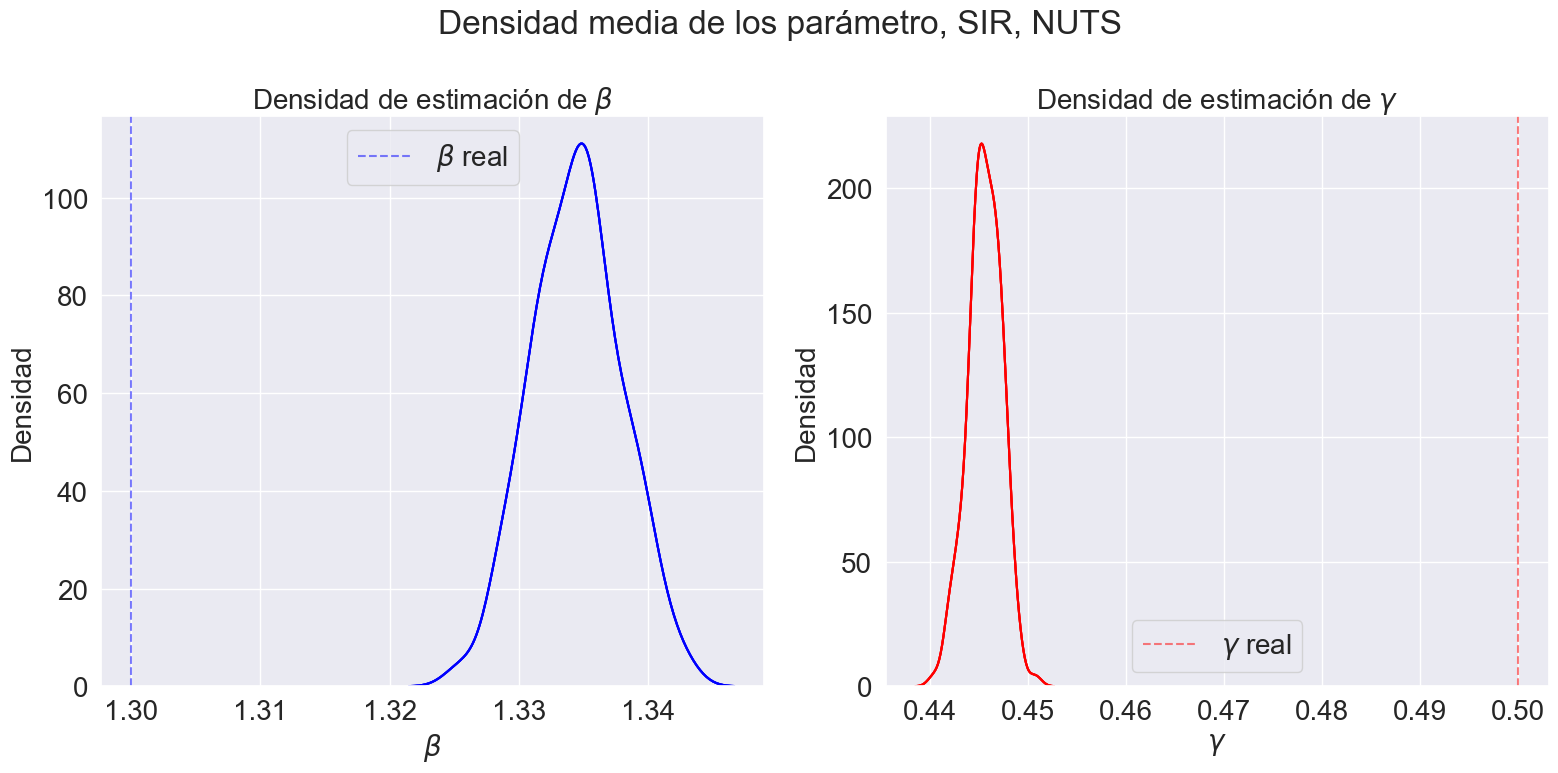

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.3, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad media de los parámetro, SIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_density_mean.pdf')

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [ ]:
def rhs_pymcode(y, t, p):
    dS_dt = p[0]*y[2]-p[1]*y[0]*y[1]
    dI_dt = p[1]*y[0]*y[1] - p[2]*y[1]
    dR_dt = p[2]*y[1]-p[0]*y[2]
    return [dS_dt, dI_dt, dR_dt]

In [ ]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=3, t0=0
)

In [ ]:
theta = [0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha = pm.Uniform("alpha", 0, 1)
    beta = pm.Uniform("beta", 0, 2)
    gamma = pm.Uniform("gamma", 0, 1)
    #sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[alpha, beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=0.01, observed=y.T)

In [ ]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
time_nuts = time() - time_nuts

In [ ]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.171,0.003,0.165,0.177,0.000,0.0,432.0,746.0,1.02
beta,1.337,0.013,1.315,1.363,0.001,0.0,357.0,383.0,1.03
gamma,0.510,0.005,0.500,0.520,0.000,0.0,316.0,436.0,1.03


In [ ]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 237.68 s


In [ ]:
params = ['alpha', 'beta', 'gamma']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SIRS_NUTS.csv", index=False)

Parámetros estimados:
alpha: 0.171 (0.16512000000000002, 0.17688)
beta: 1.337 (1.31152, 1.36248)
gamma: 0.51 (0.5002, 0.5198)


alpha: 0.171 (0.16512000000000002, 0.17688)
beta: 1.337 (1.31152, 1.36248)
gamma: 0.51 (0.5002, 0.5198)


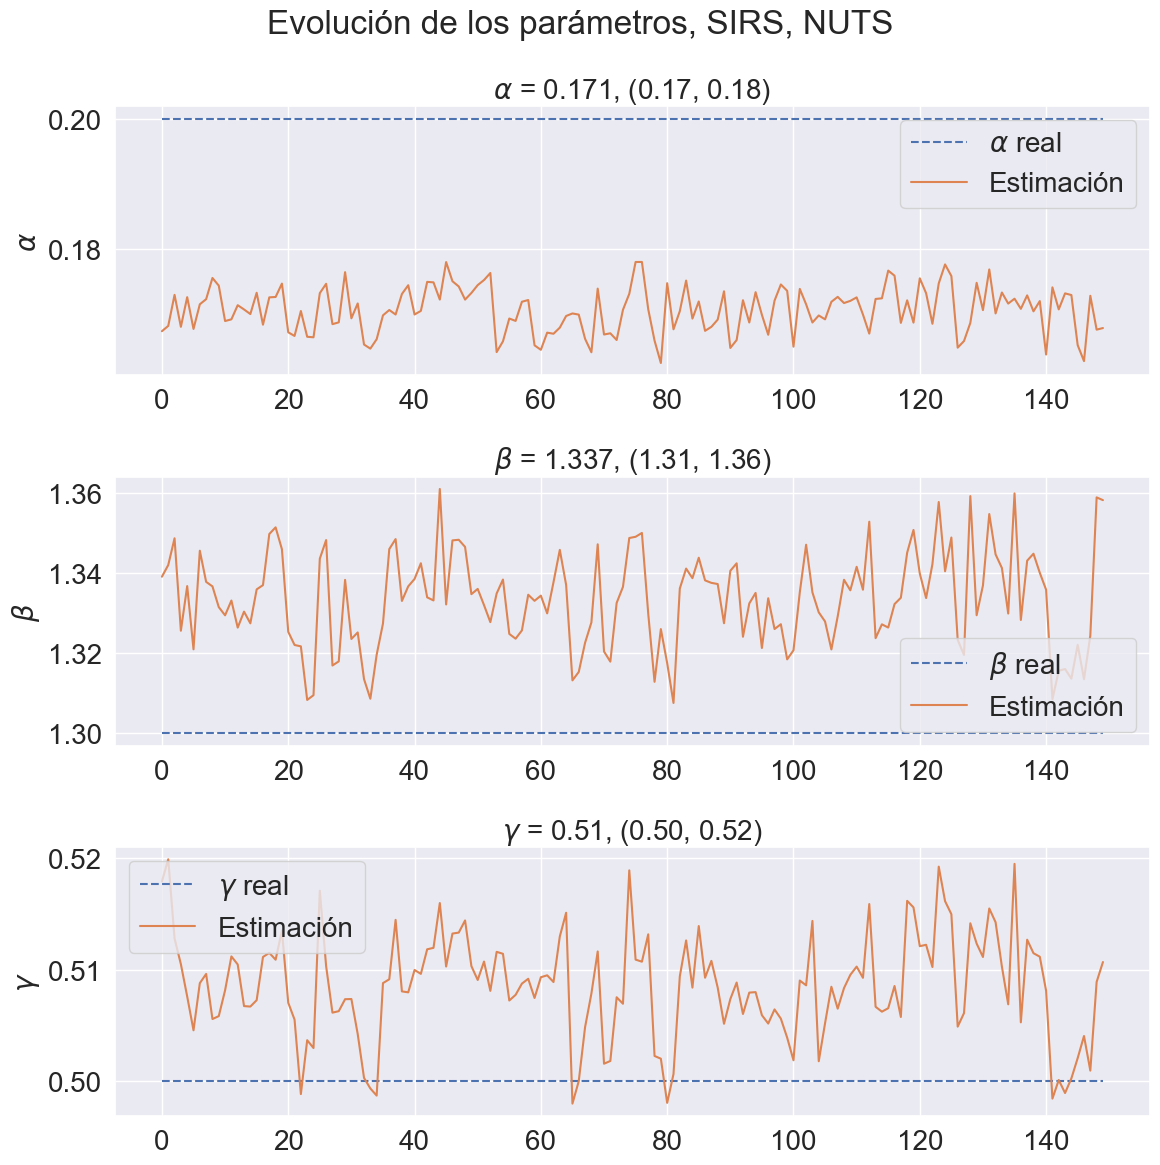

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), linestyle='--', label=r'$\alpha$ real')
ax[0].plot(trace.posterior["alpha"][0], label='Estimación')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[1].plot(trace.posterior["beta"][0], label='Estimación')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot([0.5]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[2].plot(trace.posterior["gamma"][0], label='Estimación')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

fig.suptitle('Evolución de los parámetros, SIRS, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sirs_params_trace.pdf')

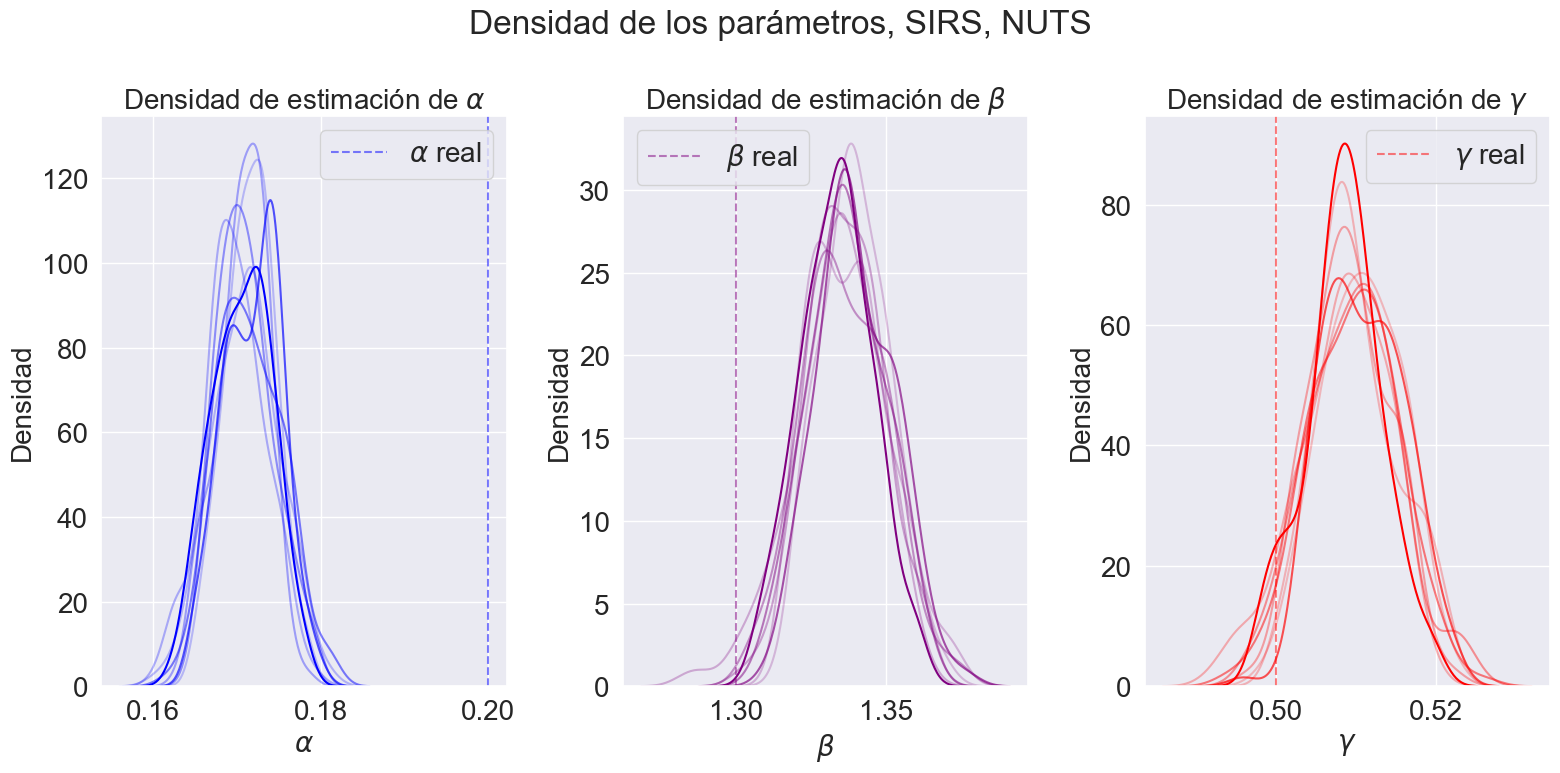

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de los parámetros, SIRS, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sirs_params_density_mean.pdf')

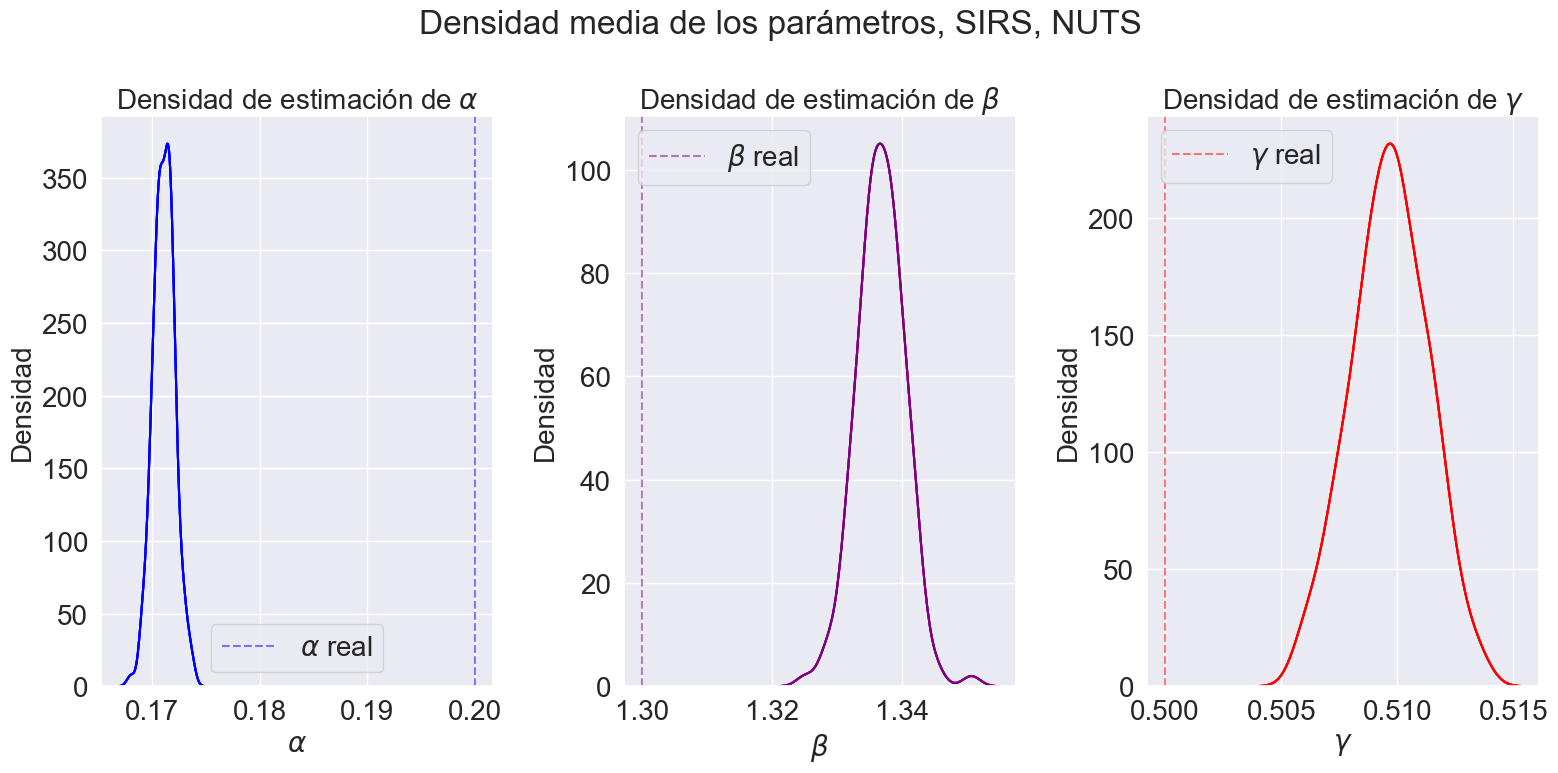

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad media de los parámetros, SIRS, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sirs_params_density.pdf')

## SEIR

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma, delta):
    S, E, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - delta*E,
        delta*E - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[2]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.4
delta = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma, delta)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

def rhs_pymcode(y, t, p):
    dS_dt = p[0]*y[3]-p[1]*y[0]*y[2]
    dE_dt = p[1]*y[0]*y[2] - p[2]*y[1]
    dI_dt = p[2]*y[1] - p[3]*y[2]
    dR_dt = p[3]*y[2]-p[0]*y[3]
    return [dS_dt, dE_dt, dI_dt, dR_dt]

ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=4, n_theta=4, t0=0
)

theta = [0.1, 0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha = pm.Uniform("alpha", 0, 1)
    beta = pm.Uniform("beta", 0, 2)
    gamma = pm.Uniform("gamma", 0, 1)
    delta = pm.Uniform("delta", 0, 1)
    #sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0, 0.0], theta=[alpha, beta, gamma, delta])[:, [0, 2]]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=0.01, observed=y.T)

In [ ]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8, random_seed=42)
time_nuts = time() - time_nuts

In [ ]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.147,0.009,0.128,0.163,0.001,0.000,272.0,386.0,1.03
beta,1.269,0.040,1.200,1.343,0.003,0.002,215.0,263.0,1.03
gamma,0.473,0.019,0.438,0.509,0.001,0.001,254.0,308.0,1.03
delta,0.389,0.008,0.375,0.404,0.001,0.000,251.0,349.0,1.02


In [ ]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 508.58 s


In [ ]:
params = ['alpha', 'beta', 'gamma', 'delta']
summ = az.summary(trace)
data = pd.DataFrame()

print("Parámetros estimados:")
for i in range(len(params)):
    data[params[i]] = [summ['mean'][params[i]], summ['sd'][params[i]]]
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

data.to_csv("csv/SEIR_NUTS.csv", index=False)

Parámetros estimados:
alpha: 0.147 (0.12936, 0.16463999999999998)
beta: 1.269 (1.1905999999999999, 1.3474)
gamma: 0.473 (0.43576, 0.51024)
delta: 0.389 (0.37332, 0.40468000000000004)


alpha: 0.147 (0.12936, 0.16463999999999998)
beta: 1.269 (1.1905999999999999, 1.3474)
gamma: 0.473 (0.43576, 0.51024)
delta: 0.389 (0.37332, 0.40468000000000004)


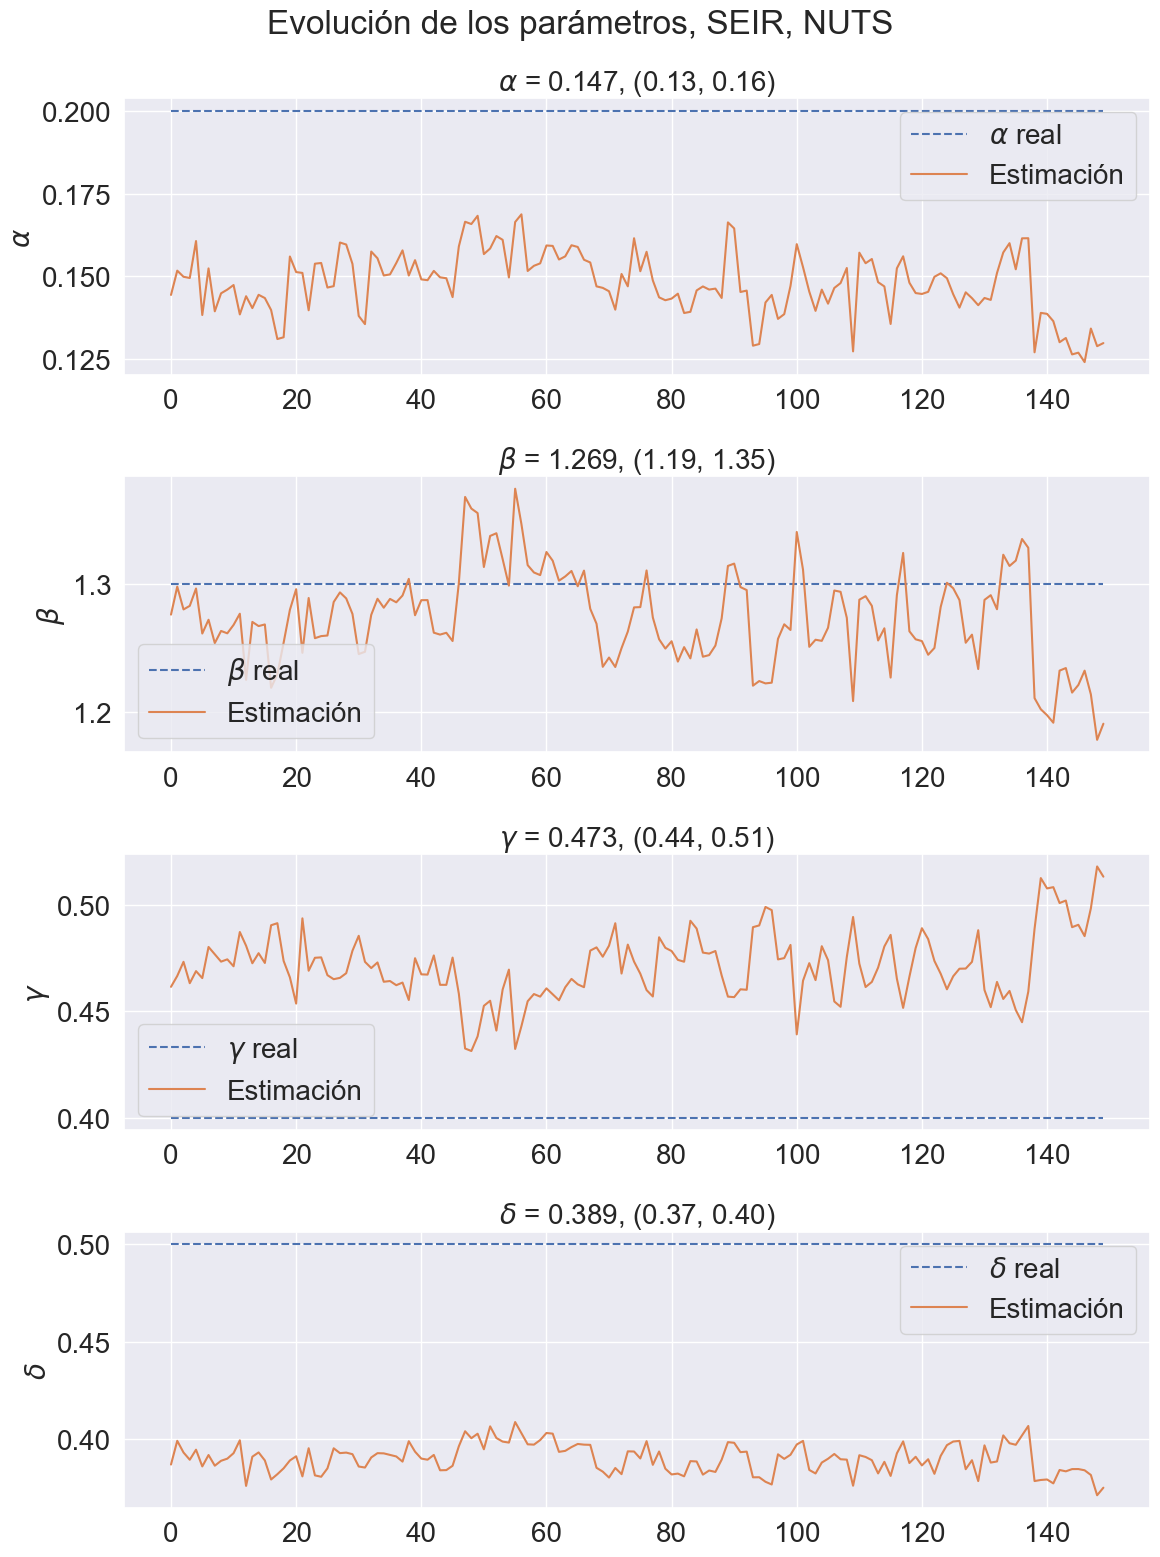

In [ ]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), linestyle='--', label=r'$\alpha$ real')
ax[0].plot(trace.posterior["alpha"][0], label='Estimación')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[1].plot(trace.posterior["beta"][0], label='Estimación')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot([0.4]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[2].plot(trace.posterior["gamma"][0], label='Estimación')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

z1 = summ['mean']['delta'] - 1.96*summ['sd']['delta']
z2 = summ['mean']['delta'] + 1.96*summ['sd']['delta']
print(f"{'delta'}: {summ['mean']['delta']} ({z1}, {z2})")

ax[3].plot([0.5]*len(trace.posterior["delta"][0]), linestyle='--', label=r'$\delta$ real')
ax[3].plot(trace.posterior["delta"][0], label='Estimación')
ax[3].set_title(r'$\delta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['delta'], z1, z2))
ax[3].set_ylabel(r'$\delta$')
ax[3].legend()

plt.suptitle('Evolución de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_trace.pdf')

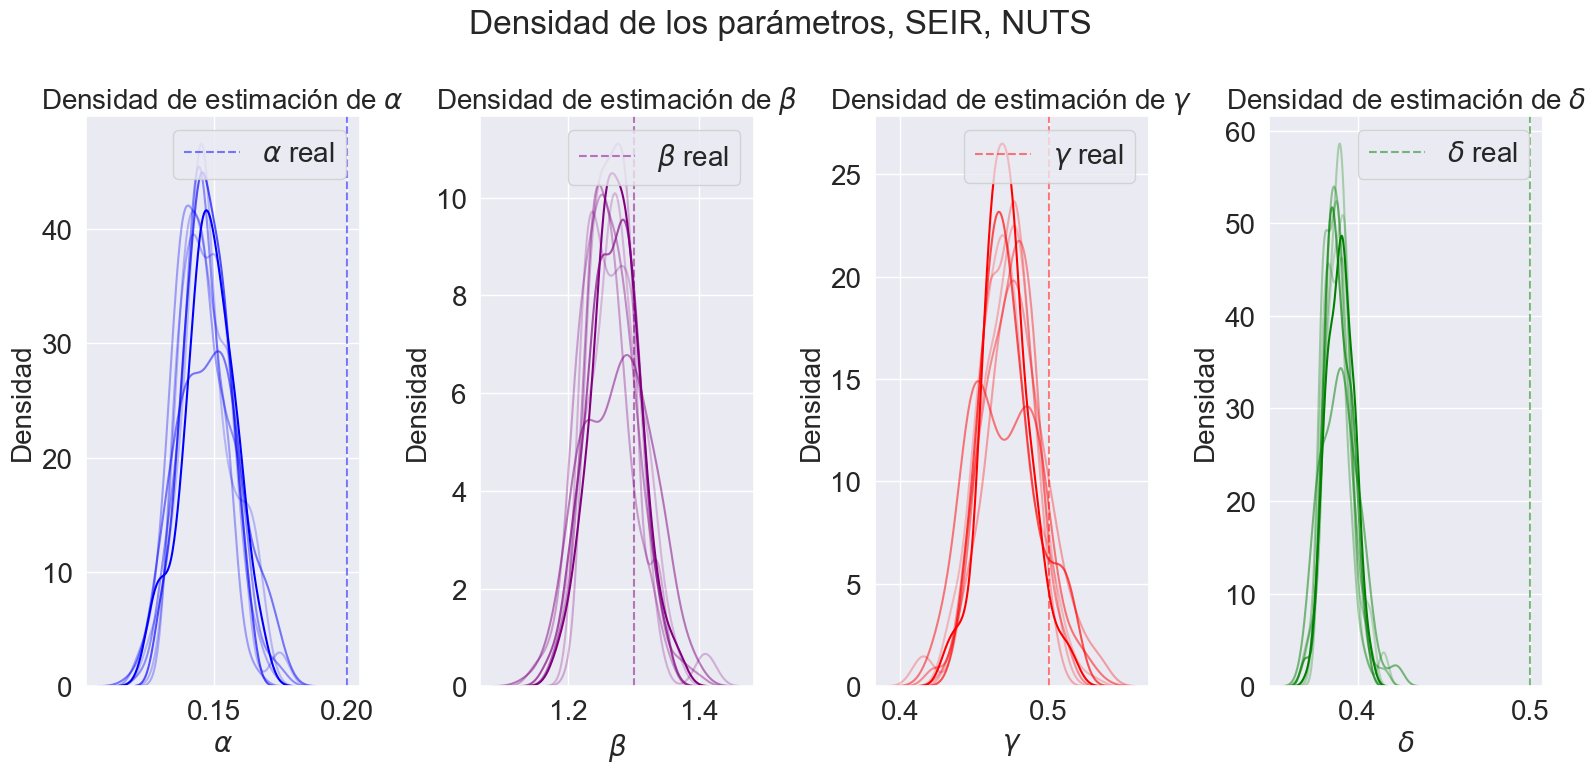

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"][i], ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(0.5, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_density.pdf')

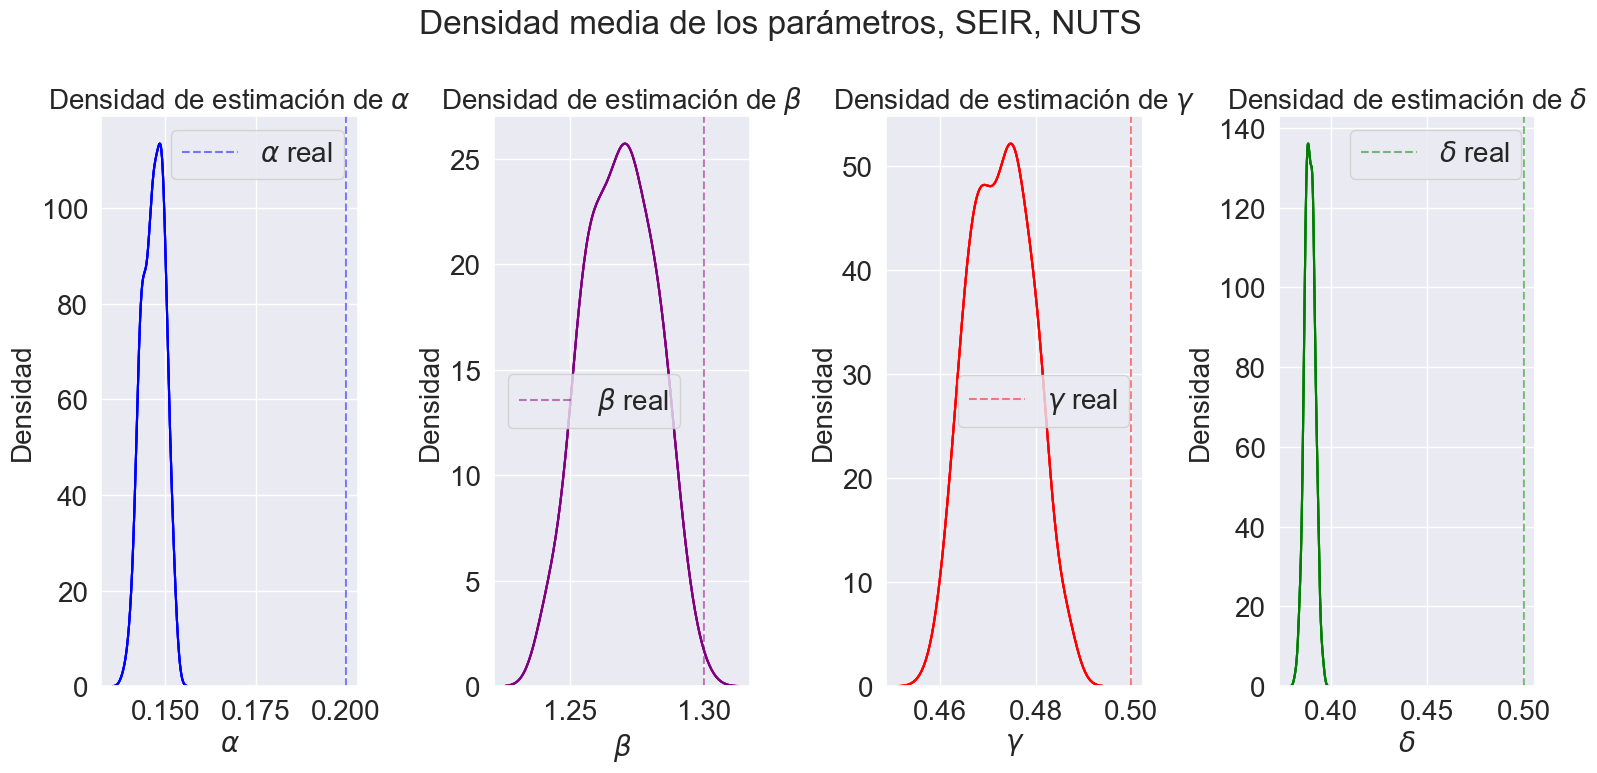

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"].mean(axis=0), ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(0.5, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad media de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_density_mean.pdf')